# Probabilistic Knowledge Graph

## Load data

In [1]:
import pandas as pd

Xy = pd.read_csv('./stash/Xy.csv') \
    .sample(frac=1, random_state=37) \
    .reset_index(drop=True)

X = Xy[Xy.columns.drop(['y', 'title'])]
t = Xy['title']
y = Xy['y']

Xy.shape, X.shape, t.shape, y.shape

((90, 1538), (90, 1536), (90,), (90,))

In [2]:
X

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x1526,x1527,x1528,x1529,x1530,x1531,x1532,x1533,x1534,x1535
0,-0.019507,0.013445,0.010537,-0.014153,-0.001773,0.004635,-0.008861,-0.002329,-0.052582,-0.024602,...,-0.019166,-0.008650,0.030051,-0.000228,-0.009965,-0.030732,-0.000871,-0.032257,-0.019166,-0.017055
1,-0.000022,-0.012102,0.007365,-0.019335,-0.015435,0.016306,-0.021562,-0.008305,-0.007987,-0.026942,...,0.027716,0.014397,0.007752,-0.037812,-0.039749,-0.021949,0.008423,-0.006511,-0.000435,-0.010808
2,0.009569,0.010092,0.015664,-0.019369,-0.011619,0.014890,-0.036974,-0.014673,-0.013404,-0.018569,...,-0.011436,0.001428,0.007879,-0.027228,-0.010825,-0.010404,0.008341,-0.031355,0.001314,-0.008049
3,-0.019494,-0.002276,0.020209,-0.017049,0.005020,0.028324,-0.012049,0.000273,-0.025840,-0.012718,...,0.002287,-0.014578,0.031679,-0.014435,-0.035710,-0.023473,0.027830,-0.011737,-0.017322,-0.006704
4,0.008369,0.006958,0.007848,-0.016671,0.002301,0.021481,-0.028651,-0.016566,-0.023682,-0.009878,...,0.004639,-0.000299,0.018964,-0.029389,-0.020651,-0.020414,0.013047,-0.026582,0.008217,-0.023406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.001792,0.002270,0.018924,-0.020669,-0.012502,0.011180,-0.002756,-0.017072,-0.005768,-0.031352,...,0.019796,0.011254,0.017058,-0.030734,-0.046759,-0.016052,0.015287,-0.020507,-0.002099,-0.014092
86,0.008665,-0.000370,0.029389,-0.022449,-0.016175,0.014124,0.001330,0.005684,-0.030992,-0.035609,...,-0.001462,-0.011958,-0.005599,-0.024867,-0.028547,-0.001550,0.014491,-0.030666,-0.011116,-0.032404
87,-0.011600,-0.002251,0.014354,-0.036543,-0.006796,0.017575,-0.014065,-0.001875,-0.033599,-0.008807,...,-0.009359,0.000499,0.011364,-0.013414,-0.023240,-0.035018,0.009123,-0.028735,-0.026947,0.000290
88,-0.003680,-0.006394,0.009125,-0.028772,-0.021632,0.022692,-0.022075,-0.007059,-0.006884,-0.022115,...,0.019177,-0.008776,0.035750,-0.027255,-0.024236,-0.018935,-0.013567,-0.013104,-0.012178,0.006549


In [3]:
y

0     machine_learning
1               python
2                 java
3     computer_science
4           javascript
            ...       
85              python
86          javascript
87    machine_learning
88    computer_science
89         real_estate
Name: y, Length: 90, dtype: object

## Kmeans testing

In [4]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

def get_model(X, n_estimators=20, n_clusters=2):
    clusterer = KMeans(n_clusters=n_clusters, n_init='auto').fit(X)
    y = clusterer.predict(X)

    classifier = RandomForestClassifier(random_state=37, n_estimators=n_estimators)
    classifier.fit(X, y)

    return clusterer, classifier

def get_performance(X, m):
    y_c = m[0].predict(X)

    unique_values = sorted(np.unique(y_c))
    y_c = np.array([[1 if c == v else 0 for c in range(m[0].n_clusters) if c in unique_values] for v in m[0].predict(X_te)])

    y_p = m[1].predict_proba(X)[:, unique_values]

    if y_p.shape[1] > 2:
        roc = roc_auc_score(y_c, y_p, multi_class='ovr')
        aps = average_precision_score(y_c, y_p)
    else:
        y_c = y_c[:,1]
        y_p = y_p[:,1]

        roc = roc_auc_score(y_c, y_p, multi_class='ovr')
        aps = average_precision_score(y_c, y_p)

    return {
        'roc': roc,
        'aps': aps
    }

In [5]:
tr, te = next(ShuffleSplit(n_splits=5, test_size=0.2, random_state=37).split(X))

X_tr = X.iloc[tr]
X_te = X.iloc[te]

X_tr.shape, X_te.shape

((72, 1536), (18, 1536))

In [6]:
for n_clusters in range(2, 10):
    m = get_model(X_tr, n_estimators=10, n_clusters=n_clusters)
    print({**{'n_clusters': n_clusters}, **get_performance(X_te, m)})

{'n_clusters': 2, 'roc': 0.9666666666666667, 'aps': 0.8666666666666667}
{'n_clusters': 3, 'roc': 0.8886217948717948, 'aps': 0.7282051282051283}
{'n_clusters': 4, 'roc': 0.984375, 'aps': 0.9625}
{'n_clusters': 5, 'roc': 0.9697657952069717, 'aps': 0.7573599240265907}
{'n_clusters': 6, 'roc': 0.9611519607843138, 'aps': 0.7899603174603176}
{'n_clusters': 7, 'roc': 0.9944444444444445, 'aps': 0.9583333333333333}
{'n_clusters': 8, 'roc': 0.9531349206349207, 'aps': 0.8790151515151514}
{'n_clusters': 9, 'roc': 0.9232142857142858, 'aps': 0.8855555555555557}


## Divisive clustering

In [7]:
def divisive_clustering(X, num_clusters):
    num_points = X.shape[0]
    labels = np.zeros(num_points, dtype=int)
    cluster_index = 0
    clusters = [(X, cluster_index)]
    edges = []
    
    while len(set(labels)) < num_clusters and len(clusters) > 0:
        # Sort clusters by their size (descending) to always split the biggest cluster
        clusters.sort(key=lambda x: len(x[0]), reverse=True)
        cluster_to_split, cluster_index = clusters.pop(0)
        
        if len(cluster_to_split) > 1:  # Need at least two points to split
            # Use KMeans with k=2 to split the cluster
            kmeans = KMeans(n_clusters=2, n_init='auto', random_state=42).fit(cluster_to_split)
            split_labels = kmeans.labels_
            
            # Find indices in the original dataset
            original_indices = np.where(labels == cluster_index)[0]
            if len(original_indices) == 0:  # If this is the first split
                original_indices = range(num_points)
            
            # Update labels for the split clusters
            # Find which indices correspond to each split label and update
            labels[original_indices[split_labels == 0]] = cluster_index  # Keep current index for one split
            new_cluster_index = max(labels) + 1  # Create a new index for the other split
            labels[original_indices[split_labels == 1]] = new_cluster_index
            
            # Add the new clusters back with their indices for further splits if needed
            clusters.append((cluster_to_split[split_labels == 0], cluster_index))
            clusters.append((cluster_to_split[split_labels == 1], new_cluster_index))

            print(f'{cluster_index=}, {new_cluster_index=}, {len(cluster_to_split[split_labels == 0])=}, {len(cluster_to_split[split_labels == 1])=}')
            edges.append((cluster_index, new_cluster_index))
    
    return labels, edges

In [8]:
y_pred, edges = divisive_clustering(X, 15)
y_pred

cluster_index=0, new_cluster_index=1, len(cluster_to_split[split_labels == 0])=57, len(cluster_to_split[split_labels == 1])=33
cluster_index=0, new_cluster_index=2, len(cluster_to_split[split_labels == 0])=38, len(cluster_to_split[split_labels == 1])=19
cluster_index=0, new_cluster_index=3, len(cluster_to_split[split_labels == 0])=12, len(cluster_to_split[split_labels == 1])=26
cluster_index=1, new_cluster_index=4, len(cluster_to_split[split_labels == 0])=4, len(cluster_to_split[split_labels == 1])=29
cluster_index=4, new_cluster_index=5, len(cluster_to_split[split_labels == 0])=10, len(cluster_to_split[split_labels == 1])=19
cluster_index=3, new_cluster_index=6, len(cluster_to_split[split_labels == 0])=5, len(cluster_to_split[split_labels == 1])=21
cluster_index=6, new_cluster_index=7, len(cluster_to_split[split_labels == 0])=12, len(cluster_to_split[split_labels == 1])=9
cluster_index=2, new_cluster_index=8, len(cluster_to_split[split_labels == 0])=5, len(cluster_to_split[split_label

array([ 7, 11, 12,  7,  5, 13,  6,  7,  5, 11,  9,  8,  9,  0,  9,  3,  8,
        0,  2, 10, 10,  3, 11, 10,  4,  0,  2, 14,  8,  4,  0, 11, 14, 12,
        3, 14, 14, 11,  1, 12,  3,  5,  5,  8, 10,  6,  7,  2,  4, 12,  5,
       11,  1, 10,  9,  5, 13,  6,  9, 12,  7,  1, 13, 10, 12,  0,  7,  5,
        9,  7, 12, 13, 10,  5, 10, 10,  2,  1,  7, 12, 12,  4, 14,  2, 14,
       11, 13,  7,  3, 10])

In [25]:
X.assign(title=t, y=y, c=y_pred).to_csv('./stash/Xytc.csv', index=False)

## Graphical model

In [9]:
edges = [(f'c{pa}', f'c{ch}') for pa, ch in edges]

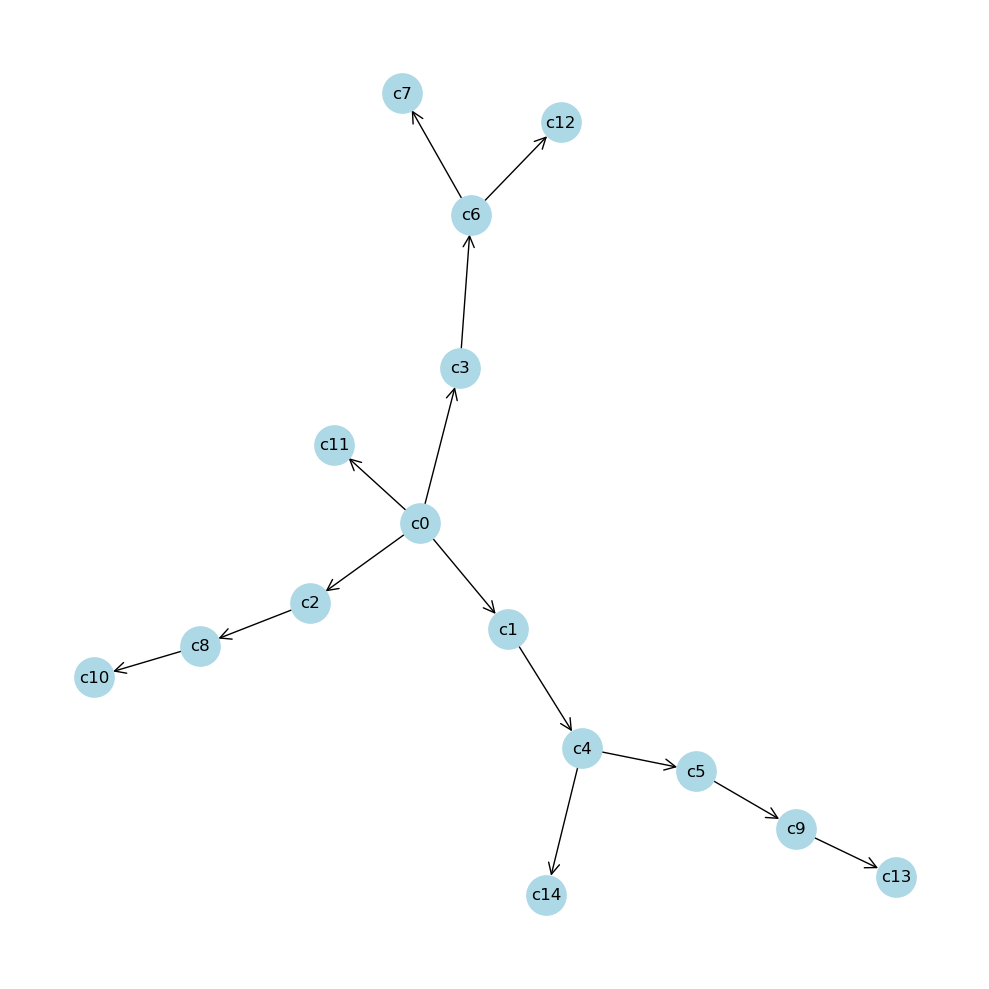

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.DiGraph()
g.add_edges_from(edges)

g.nodes(), g.edges()

pos = nx.nx_agraph.graphviz_layout(g, prog='neato')

fig, ax = plt.subplots(figsize=(10, 10))

nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=800, arrowstyle='->', arrowsize=20, ax=ax)

fig.tight_layout()

## Parameter models

In [11]:
c2p = {ch: pa for pa, ch in edges}
c2p

{'c1': 'c0',
 'c2': 'c0',
 'c3': 'c0',
 'c4': 'c1',
 'c5': 'c4',
 'c6': 'c3',
 'c7': 'c6',
 'c8': 'c2',
 'c9': 'c5',
 'c10': 'c8',
 'c11': 'c0',
 'c12': 'c6',
 'c13': 'c9',
 'c14': 'c4'}

In [12]:
Y = pd.DataFrame({
    'title': t, 
    'y_true': y, 
    'y_pred': y_pred,
    'ch': [f'c{n}' for n in y_pred],
    'pa': [c2p[f'c{n}'] if f'c{n}' in c2p else '*' for n in y_pred]
    }) \
    .sort_values(['y_pred'])
Y.head()

,title,y_true,y_pred,ch,pa
17,Python for Data Analysis,python,0,c0,*
13,Introduction to Machine Learning with Python,machine_learning,0,c0,*
65,Automate the Boring Stuff with Python,python,0,c0,*
25,Python Machine Learning,machine_learning,0,c0,*
30,Python Data Science Handbook,python,0,c0,*


In [13]:
def get_purity(y_pred, Y):
    s = Y[Y['y_pred']==y_pred]['y_true'].value_counts()
    p = s / s.sum()
    p = p.sort_values(ascending=False).iloc[0]
    n = Y[Y['y_pred']==y_pred].shape[0]
    
    return {
        'y_pred': y_pred,
        'n': n,
        'p': p
    }

pd.DataFrame([get_purity(y_pred, Y) for y_pred in Y['y_pred'].unique()])

,y_pred,n,p
0,0,5,0.600000
1,1,4,0.750000
2,2,5,1.000000
3,3,5,0.600000
4,4,4,1.000000
5,5,8,0.500000
6,6,3,1.000000
7,7,9,0.777778
8,8,4,1.000000
9,9,6,0.500000


In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(Y.sort_values(['y_pred']))

,title,y_true,y_pred,ch,pa
17,Python for Data Analysis,python,0,c0,*
13,Introduction to Machine Learning with Python,machine_learning,0,c0,*
65,Automate the Boring Stuff with Python,python,0,c0,*
25,Python Machine Learning,machine_learning,0,c0,*
30,Python Data Science Handbook,python,0,c0,*
77,CSS Secrets: Better Solutions to Everyday Web ...,web,1,c1,c0
61,HTML & CSS: Design and Build Websites,web,1,c1,c0
38,Design Patterns: Elements of Reusable Object-O...,computer_science,1,c1,c0
52,Responsive Web Design with HTML5 and CSS,web,1,c1,c0
18,The Total Money Makeover,finance,2,c2,c0


In [15]:
def get_potential(node_id, df, c2p):
    if node_id in c2p:
        pa = c2p[node_id]
        
        s11 = df[(df['ch']==node_id) & (df['pa']==pa)].shape[0] / df[df['pa']==pa].shape[0]
        if s11 == 1.0:
            s11 = 0.99
        s10 = 1 - s11
        
        return pd.DataFrame([
            {pa: 1, node_id: 1, '__p__': s11}, 
            {pa: 1, node_id: 0, '__p__': s10},
            {pa: 0, node_id: 1, '__p__': 0.01}, 
            {pa: 0, node_id: 0, '__p__': 0.99}
        ])
    else:
        s1 = df[df['ch']==node_id].shape[0]
        s0 = df[df['pa']==node_id].shape[0]
        p1 = s1 / (s1 + s0)
        p0 = s0 / (s1 + s0)

        p0 = 0.01
        p1 = 0.99
        
        return pd.DataFrame([
            {node_id: 0, '__p__': p0}, 
            {node_id: 1, '__p__': p1}
        ])

p = {n: get_potential(n, Y, c2p).to_dict(orient='split', index=False) for n in g.nodes()}
p

{'c0': {'columns': ['c0', '__p__'], 'data': [[0, 0.01], [1, 0.99]]},
 'c1': {'columns': ['c0', 'c1', '__p__'],
  'data': [[1, 1, 0.19047619047619047],
   [1, 0, 0.8095238095238095],
   [0, 1, 0.01],
   [0, 0, 0.99]]},
 'c2': {'columns': ['c0', 'c2', '__p__'],
  'data': [[1, 1, 0.23809523809523808],
   [1, 0, 0.7619047619047619],
   [0, 1, 0.01],
   [0, 0, 0.99]]},
 'c3': {'columns': ['c0', 'c3', '__p__'],
  'data': [[1, 1, 0.23809523809523808],
   [1, 0, 0.7619047619047619],
   [0, 1, 0.01],
   [0, 0, 0.99]]},
 'c4': {'columns': ['c1', 'c4', '__p__'],
  'data': [[1, 1, 0.99],
   [1, 0, 0.010000000000000009],
   [0, 1, 0.01],
   [0, 0, 0.99]]},
 'c5': {'columns': ['c4', 'c5', '__p__'],
  'data': [[1, 1, 0.5714285714285714],
   [1, 0, 0.4285714285714286],
   [0, 1, 0.01],
   [0, 0, 0.99]]},
 'c6': {'columns': ['c3', 'c6', '__p__'],
  'data': [[1, 1, 0.99],
   [1, 0, 0.010000000000000009],
   [0, 1, 0.01],
   [0, 0, 0.99]]},
 'c7': {'columns': ['c6', 'c7', '__p__'],
  'data': [[1, 1, 0.5]

## Reasoning model

In [16]:
from pybbn.reasoning import create_reasoning_model

model = create_reasoning_model(g, p)

In [17]:
# q = model.pquery()
# q = model.pquery(evidences=model.e({0: 1, 13: 1}))
q = model.pquery(evidences=model.e({'c13': 1}))

In [18]:
for _q in q:
    display(q[_q])

,c0,__p__
0,0,0.011807
1,1,0.988193


,c1,__p__
0,0,0.260422
1,1,0.739578


,c2,__p__
0,0,0.764598
1,1,0.235402


,c3,__p__
0,0,0.908407
1,1,0.091593


,c4,__p__
0,0,0.218253
1,1,0.781747


,c5,__p__
0,0,0.157163
1,1,0.842837


,c6,__p__
0,0,0.908324
1,1,0.091676


,c7,__p__
0,0,0.745
1,1,0.255


,c8,__p__
0,0,0.759306
1,1,0.240694


,c9,__p__
0,0,0.078668
1,1,0.921332


,c10,__p__
0,0,0.75412
1,1,0.24588


,c11,__p__
0,0,0.66763
1,1,0.33237


,c12,__p__
0,0,0.871862
1,1,0.128138


,c13,__p__
0,0,0.0
1,1,1.0


,c14,__p__
0,0,0.59201
1,1,0.40799


## Save

In [19]:
from pybbn.serde import model_to_dict
import json

with open('./stash/model.json', 'w') as fp:
    json.dump(model_to_dict(model), fp, indent=1)